# Molecular Maps: PCA using RDKIT

Author: AlvaroVM [https://alvarovm.github.io](http://alvarovm.github.io)
Version: 0.0.1

## Example 1: PCA to distinguish between rings and chains

For this example we define in SMILES string two groups of molecules with different substituents, such as -CH3, -O, -F, -Cl, and- I , in molecules with six carbons 1) in a ring and 2) in chain. Those molecules would be added to a list, additionally we add a 'certain' property , this could be used later as a flag.

In [1]:
smile_ring=["Cc1ccccc1", "Oc1ccccc1","Fc1ccccc1","Clc1ccccc1","Ic1ccccc1"]
values_ring = [1.2, 1.3, 1.4, 1.5, 1.6]
smile_chain=["CC=CC=CC=C","OC=CC=CC=C","FC=CC=CC=C","ClC=CC=CC=C","IC=CC=CC=C"]
values_chain = [2.2, 2.3, 2.4, 2.5, 2.6]
smile=[]
values=[]
smile= smile +smile_ring+smile_chain
values=values +values_ring +values_chain
#smile

We load *rdkit*  and *numpy* 

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs 
from rdkit.Chem import Draw
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

We create a list of RDKIT molecular objects, and we plot it. We expect to have two main groups in those molecules.  

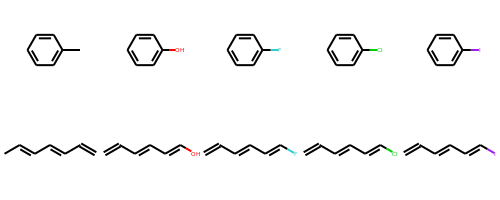

In [3]:
molobj = [Chem.MolFromSmiles(smi) for smi in smile]
#Draw.MolsToGridImage(molobj[:8],molsPerRow=4,subImgSize=(200,200),legends=[x.GetProp("_Name") for x in molobj[:8]])
Draw.MolsToGridImage(molobj,molsPerRow=5,subImgSize=(100,100))

We create a list of RDKIT molecular objects and compute the Morgan Finger Print (here with 1024 bits and radii 2), and we produce a distance matrix (covariance matrix) using the Tanimoto similarity.

In [4]:
def get_molcov(mobj):
    fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) for mol in mobj]
    
    dists = []
    nfps = len(fps)
    cov_mat = np.zeros((nfps,nfps))

    for i in range(0,nfps):
        for j in range(0, nfps):
            cov_mat[i,j]  =  DataStructs.FingerprintSimilarity(fps[i],fps[j], metric=DataStructs.TanimotoSimilarity)
    return  cov_mat

In [5]:
distmat = get_molcov(molobj)

In [6]:
#for m in molobj: tmp=AllChem.Compute2DCoords(m)

In [ ]:
#molobj[6].GetBondWithIdx(0).GetBondType()
#molobj[6].GetBondWithIdx(0).GetIsAromatic()

In [ ]:
#for e in molobj:
    #print (e.GetRingInfo().NumAtomRings(1))
    #print (e.GetBondWithIdx(1).GetIsAromatic())

Then we compute the eigen vectors and eigen values of the distance matrix using numpy.

In [7]:
eival, eivec = np.linalg.eig(distmat)
print ("Eigen Values\n", eival)

Eigen Values
 [0.64591942 0.53463614 2.49335373 2.78442405 0.53463614 0.64591942
 0.64591942 0.64591942 0.53463614 0.53463614]


Optionally we can verify that the eigen vectors are normalized.

In [ ]:
#for ev in eivec:
#    print (np.linalg.norm(ev))

We need to sort the most relevant vectors which would has the most highest eigen values. To this purpose we pair Eigen Values and Eigen Vectors

In [8]:
eig_pair = [(np.abs(eival[i]), eivec[:,i]) for i in range(len(eival))]

And we sort those pairs

In [16]:
eig_pair.sort(key=lambda x : x[0], reverse=True)
#two vectors with highest values
print("The two vectors with highest values:\n",
      "PC1: \n", eig_pair[0],"\n",
      "PC2: \n",eig_pair[1] )

The two vectors with highest values:
 PC1: 
 (2.784424048300737, array([-0.06757795, -0.06757795, -0.06757795, -0.06757795, -0.06757795,
       -0.4420783 , -0.4420783 , -0.4420783 , -0.4420783 , -0.4420783 ])) 
 PC2: 
 (2.493353729477039, array([-0.4420783 , -0.4420783 , -0.4420783 , -0.4420783 , -0.4420783 ,
        0.06757795,  0.06757795,  0.06757795,  0.06757795,  0.06757795]))


Create matrix

In [18]:
nfps=len(molobj)
matrix_w = np.hstack((eig_pair[0][1].reshape(nfps,1),
                      eig_pair[1][1].reshape(nfps,1)))

In [20]:
#matrix_w

Now we plot the two principal components with higher eigenvalues. The points are colored with the property values we arbitarly defined above. In this plot clearly can be seen two features of two main molecular groups, molecules with a chain or with a ring.

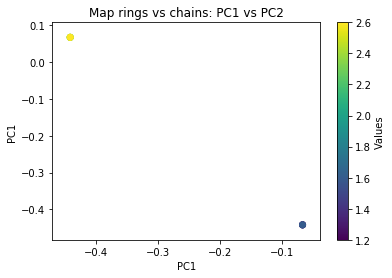

In [21]:
plt.figure()
plt.scatter(matrix_w[:, 0], matrix_w[:,1], marker='o', c=values[:])
plt.xlabel('PC1')
plt.ylabel('PC1')
plt.title('Map rings vs chains: PC1 vs PC2')
cbar = plt.colorbar()
cbar.set_label('Values')

Alternatively, it is possible to create a scatter plot with property values against PC1, and use PC1 as color.

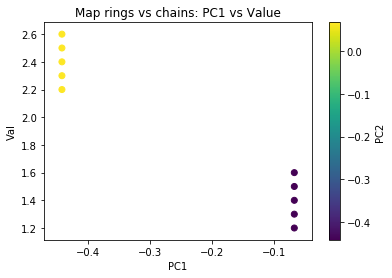

In [22]:
plt.figure()
plt.scatter(matrix_w[:, 0], values[:], marker='o', c=matrix_w[:,1])
plt.xlabel('PC1')
plt.ylabel('Val')
plt.title('Map rings vs chains: PC1 vs Value')
cbar = plt.colorbar()
cbar.set_label('PC2')

## Adding a molecule with a chain and a ring

Now we add new molecule wich has both a chain and ring of carbons.

In [23]:
smile_hy="CC=CC=Cc1ccccc1"
values_hy=1.9
#smile_hy

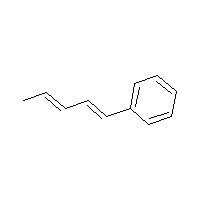

In [24]:
m = Chem.MolFromSmiles(smile_hy)
Draw.MolToImage(m, size=(200,200))

We add the new molecular object to the origial `molobj` list and its respective value.

In [25]:
molobj.append(m)
values.append(values_hy)

And we run the same previous instructions for this new set. The new *hybri*  molecule should be located between the two groups of chains and rings.


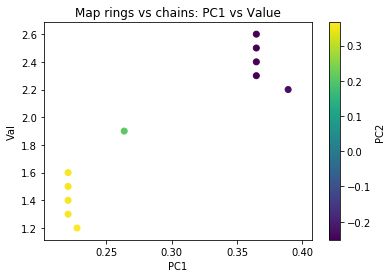

In [26]:
distmat_2 = get_molcov(molobj)
eival, eivec = np.linalg.eig(distmat_2)
eig_pair = [(np.abs(eival[i]), eivec[:,i]) for i in range(len(eival))]
eig_pair.sort(key=lambda x : x[0], reverse=True)

nfps=len(molobj)
matrix_w = np.hstack((eig_pair[0][1].reshape(nfps,1),
                      eig_pair[1][1].reshape(nfps,1)))

plt.figure()
plt.scatter(matrix_w[:, 0], values[:], marker='o', c=matrix_w[:,1])
plt.xlabel('PC1')
plt.ylabel('Val')
plt.title('Map rings vs chains: PC1 vs Value')
cbar = plt.colorbar()
cbar.set_label('PC2')